In [1]:
from skimage.io import imread
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from skimage.color import gray2rgb, rgb2gray

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from torchviz import make_dot
from joblib import Parallel, delayed, parallel_backend


In [2]:

def load_nuclei_data(data_path):
    images = []
    masks = []
    root = data_path
    for subdir in tqdm(os.listdir(root)):
        subfolder = os.path.join(root,subdir)
        if os.path.isdir(subfolder):
#             print(subdir)
            for subsubfolder_name in os.listdir(subfolder):
                if subsubfolder_name == 'images':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        for file in files:
                            if file.endswith('.png'):
                                images.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                if subsubfolder_name == 'masks':
                    for _,_,files in os.walk(os.path.join(subfolder,subsubfolder_name)):
                        mask = []
                        for file in files:
                            if file.endswith('.png'):
                                mask.append(imread(os.path.join(subfolder,subsubfolder_name,file)))
                        masks.append(mask)
    return images, masks
                    

In [3]:
print(torch.__version__)

1.1.0


In [4]:
train_images, train_masks = load_nuclei_data('./data/nuclei/train')
test_images,_ = load_nuclei_data('./data/nuclei/test')

print("there are %d train images"%(len(train_images)))
print("there are %d test images"%(len(test_images)))


there are 670 train images
there are 65 test images


## Note:
1. from print, we know that train images are not the same size, 4 channels-rgb+alpha. 
2. mask images are the same size as train images.

## TODO：
1. let's firstly try the simplest solution, resize them all to 256x256; **done**
2. mask could be summed together; **done**
3. better solution could be crop 256x256 from images;
4. rgb2gray, **done**.
5. use watershad for region detection: **done**
6. compute IoU and evaluation score: **done**
7. input preprocessing:
    * data augmentation/network design/training: ~~wu/zhao~~, **done** by huxiao.
    * erosion / dilation: **done, not so impressive**
    * loss function + weights: dempster-shafer distance: **huxiao**
    * load, find contour, + class, background, foreground, border: **huxiao**

In [100]:
# print("there are %d train images"%(len(train_images)))
# for image in train_images:
#     print(image.shape)
from skimage.morphology import square
from skimage.morphology import erosion

size = (256, 256)

useGray = True
useErosion = False
erosion_size = 3
useInputNormalization = True

if useGray == True:
    X = [resize(rgb2gray(x), size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
    X = np.array(X, np.float32)
else:
    X = [resize(x, size, mode='constant', anti_aliasing=True) for x in tqdm(train_images)]
    X = np.array(X, np.float32)
    X = X[:,:,:,:-1]# we don't need this alpha channel, right?


In [6]:
from skimage import measure

# thresholding to get the mask
Y = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
k = 0
Yeval = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
YwithContour = np.zeros([len(train_images),X.shape[1],X.shape[2]],np.float32)
for masks in tqdm(train_masks):
    key = 1
    ys = []
    yskey = []
    ys_with_contours = []
    for y in masks:
        ys1 = resize(y, size, mode='constant', anti_aliasing=False) > 0.5
#         yshow = np.zeros_like(ys1,np.uint8)
#         yshow[ys1] = 128
#         yshow[contours[:,:,0],contours[:,:,1]]=255
#         plt.imshow(yshow)
#         break
        
        ys.append(ys1)
        ys2 = ys1 * key
        key += 1
        yskey.append(ys2)
        ys_with_contour = np.zeros_like(ys1,np.float32)
        ys_with_contour[ys1] = 1
        
        ## add contour detection
        contours = measure.find_contours(ys1, 0.5)
        for c in contours:
            c = np.array(c,np.int)
            ys_with_contour[c[:,0],c[:,1]]=2 ## 3 class, 3 labels
        ys_with_contours.append(ys_with_contour)
        
    ys = np.array(ys, np.float32)
    ys = ys.sum(axis=0)
#     print(np.unique(Y[k]))
    Y[k] = ys
    
    yskey = np.array(yskey, np.float32)
    yskey = yskey.sum(axis=0)
    Yeval[k] = yskey
    
    ys_with_contours = np.array(ys_with_contours, np.float32)
    ys_with_contours = ys_with_contours.sum(axis=0)
    ys_with_contours[ys_with_contours>2] = 2
    YwithContour[k] = ys_with_contours
#     print(np.unique(ys_with_contours))
#     break
    
#     print(np.unique(ys))
#     print(np.unique(yskey))
#     ys = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
#     ys = np.array(ys, np.float32)
    k += 1

In [7]:
for k,ys in tqdm(enumerate(Y)):
    if useErosion == True:
        Y[k] = erosion(ys,square(erosion_size))## use erosion to seperate instances
print(Y.shape)


(670, 256, 256)


In [8]:
k = 0
if useGray == True:
    Z = np.zeros([len(test_images),size[0],size[1],1],np.float32)
    print(Z.shape)
    for image in tqdm(test_images):
        image = rgb2gray(image)
        image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
        Z[k] = image[:,:,np.newaxis]
        k+=1
else:
    Z = np.zeros([len(test_images),size[0],size[1],3],np.float32)
    print(Z.shape)
    ## test image contains gray?, rgba, rgb...
    for image in tqdm(test_images):
        if image.shape[2] == 1:
            image = gray2rgb(image)
            image = resize(image, size, mode='constant', anti_aliasing=True)
        else:
            image = resize(image, size, mode='constant', anti_aliasing=True)
        image = np.array(image, np.float32)
        if image.shape[2] == 4:
            Z[k] = image[:,:,:-1]
        else:
            Z[k] = image
        k+=1

(65, 256, 256, 1)


## interface for using pytorch transforms

In [9]:
useContour = False

K = [0,1,2]

###############################
# dataset class
###############################
# combine train and test together
class NucleiSet(torch.utils.data.Dataset):
    def __init__(self, transform1, transform2, train_images, train_masks):
        'Initialization'
        self.transform1 = transform1
        self.transform2 = transform2
        # load svhn
        self.X = train_images
        self.y = train_masks
        
    def __len__(self):
        'Returns the total number of samples'
        return self.X.shape[0]

    def __getitem__(self, idx):
        'Generates one sample of data'
        data = self.X[idx]
        label = self.y[idx]
#         y = y.transpose(2,1,0)    
        data = data*255
    
#         print(data.shape)

        data = Image.fromarray(data.astype(np.uint8))
        label = label
        label = Image.fromarray(label.astype(np.uint8))
        
        if self.transform1 is not None:
            data = self.transform1(data)
        if self.transform2 is not None:
            seed = np.random.randint(2147483647) # make a seed with numpy generator 
            random.seed(seed) # apply this seed to img tranfsorms
            data = self.transform2(data)
            random.seed(seed) # apply this seed to img tranfsorms
            label = self.transform2(label)
            
        data = np.array(data,np.float32)
        label = np.array(label,np.float32)
        
        if len(data.shape) == 2:
            data = data[:,:,np.newaxis]
#             print(data.shape)
            data = np.rollaxis(data,2,0)
            data = torch.FloatTensor(data/255)
        
#         print(np.unique(label))
#         data = torch.ByteTensor(np.array(data))
#         label = torch.ByteTensor(np.array(label))

        if useContour == True:
            newlabel = np.array([label == k for k in K], np.float32)
        else:
            newlabel = label
            newlabel = newlabel[:,:,np.newaxis]
            newlabel = np.rollaxis(newlabel,2,0)
#         
#         print(newlabel.shape)
        newlabel = torch.FloatTensor(newlabel)
            
        return data,newlabel

## IF use pytorch built-in data augmentation, choose usePyAug = True

In [103]:
import torchvision.transforms as transforms
import PIL.Image as Image
import random

# split total training data
ix = np.random.choice(len(X), len(X), False)
tr, val = np.split(ix, [round(0.8*len(X))])

# input normalization
if useInputNormalization == True:
    mean = X.mean(axis=(0,1,2))
    std = X.std(axis=(0,1,2))
else:
    mean = np.array([0,0,0],dtype = np.float32)
    std = np.array([1,1,1],dtype = np.float32)

batch_size = 25

usePyAug = False
if usePyAug == False:
    
    print(X.dtype)
    X = (X - mean)/std
    print(X.dtype)
    print('mean: %s, std:%s'%(mean,std))
    
#     if useGray == True:
#         if len(X.shape) == 3
#             X = X[:,:,:,np.newaxis]
    
    print(X.shape)
    print(Y.shape)
    
    data_tr = DataLoader(list(zip((X[tr,np.newaxis]), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True) 
    
    data_val = DataLoader(list(zip((X[val,np.newaxis]), Y[val, np.newaxis])), 
                      batch_size=batch_size, shuffle=True)
else:
    image_transform = transforms.Compose([transforms.Grayscale(1)])
    geometric_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
#                                               transforms.RandomAffine(45,(0.01, 0.01),scale=(1,1)),
#                                               transforms.CenterCrop(256)
                                              transforms.RandomVerticalFlip(p=0.5)
                                             ])
                                              #transforms.ToTensor()])#
    if useContour == True:
        trainset = NucleiSet(image_transform,geometric_transform,X[tr],YwithContour[tr])
        validset = NucleiSet(image_transform,geometric_transform,X[val],YwithContour[val])
    
    
        # do the inverse frequency of each class as weights
        dummy = np.array([YwithContour == k for k in K], np.float32)
        dummy = np.rollaxis(dummy, 1)
        total = dummy.shape[0]*dummy.shape[2]*dummy.shape[3]
#         for i in range(3):
#             print(i, np.sum(dummy[:, i]))
        # do the inverse frequency of each class as weights
        _weights = np.rollaxis(np.array([total / np.sum(dummy[:, i]==1) for i in range(3)], ndmin=4),3, 1)
        _weights = _weights/_weights.sum()
#         _weights = np.reshape(_weights,3,1)
#         print(_weights.shape)
        weights = torch.tensor(_weights.astype(np.float32)).cuda()
        print(weights)
    else:
        trainset = NucleiSet(image_transform,geometric_transform,X[tr],Y[tr])
        validset = NucleiSet(image_transform,geometric_transform,X[val],Y[val])
    
    data_tr = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    data_val = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=3)


data, label = next(iter(data_tr))
print(label.shape)
print(data.shape)


float32
float32
mean: -3.3611016e-08, std:0.99999994
(670, 256, 256)
(670, 256, 256)
torch.Size([25, 1, 256, 256])
torch.Size([25, 1, 256, 256])


In [104]:
print(1/1.18312636+1/8.13063946+1/31.45625086)

0.9999999972613072


torch.Size([25, 1, 256, 256])
(670, 256, 256)


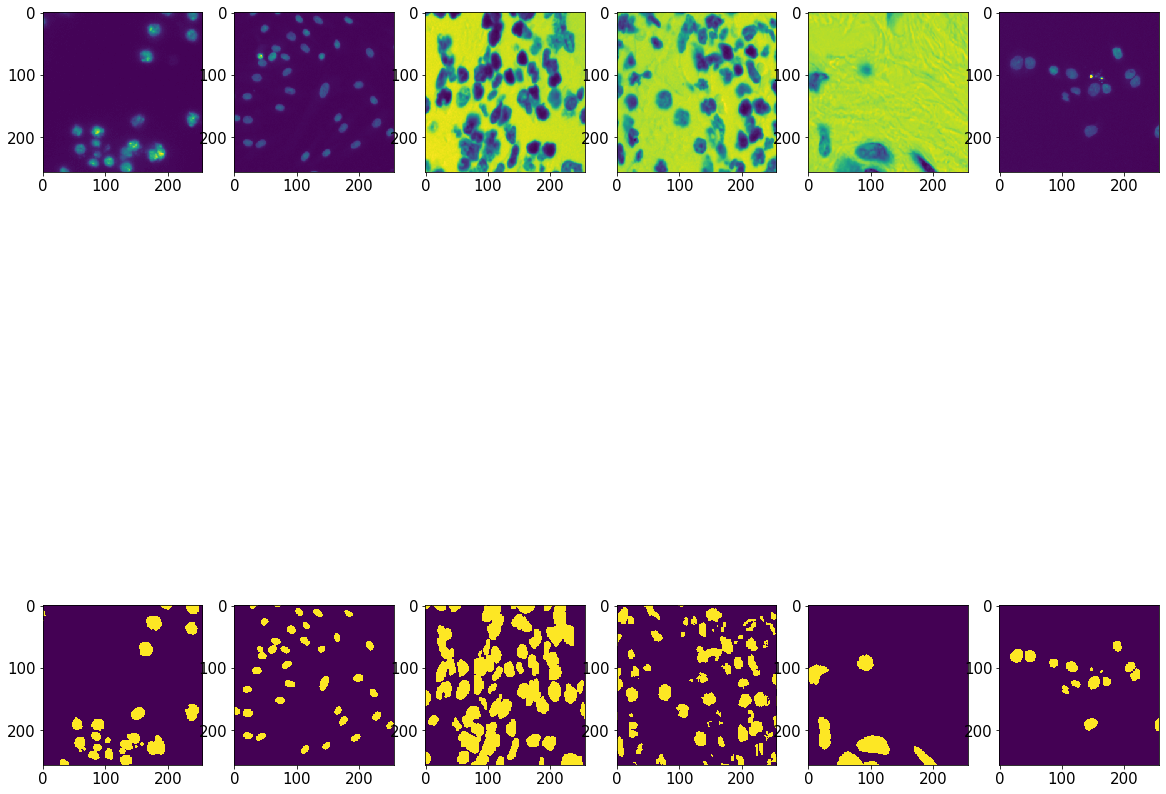

In [105]:
print(label.shape)
plt.figure(figsize=(20,20))

datas, labels = next(iter(data_tr))

if useContour == True:
    i = 1
    for data, label in zip(datas,labels):
#         print(label)
        plt.subplot(8, 8, i)
        img = data.numpy().transpose(1,2,0)
        img = img * std.mean() + mean.mean()
        plt.imshow(img[:,:,0])

        plt.subplot(8, 8, i+1)
        imgl = label.numpy().transpose(1,2,0)
#         print(imgl.shape)
        imgl_show = np.zeros_like(imgl,np.uint8)
        imgl_show[imgl[:,:,0] == 1,:] = 0
        imgl_show[imgl[:,:,1] == 1,:] = [255,0,0]
        imgl_show[imgl[:,:,2] == 1,:] = [0,0,255]
#         imgl = np.reshape(imgl,[imgl.shape[0],imgl.shape[1]])
        plt.imshow(imgl_show)
        i+=2
else:
    plt.rcParams['figure.figsize'] = [18, 6]
    print(X.shape)
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.imshow(X[i]*std+mean)

        plt.subplot(2, 6, i+7)
        plt.imshow(Y[i])
    #     print(Y[i][Y[i] == 1])
    #     break
    plt.show()

## now, ready for sematic segmentation using DL

In [106]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [107]:
def bce_loss(y_real, y_pred):
#     return torch.mean(-y_real*y_pred+torch.log(1 + torch.exp(y_pred)))
    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

# cost = nn.CrossEntropyLoss(weight=weights)
def softmax_cross_entropy_customized(y_real, y_pred):
    probs = torch.log_softmax(y_pred,1)
#     print(y_real.shape)
    cost = y_real * probs * weights
#     print(cost.shape)
    return -torch.mean(cost)
#     return -torch.mean(y_real * probs * weights) ## could add weight, todo

def train(model, opt, loss_fn, epochs, data_tr, data_val,verbose=False,show_image=True):
    for epoch in tqdm(range(epochs)):
        X_val, Y_val = next(iter(data_val))
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        if useContour == False:
            Y_hat = F.sigmoid(model(X_val.to(device))).detach().cpu()
        else:
            Y_hat = F.softmax(model(X_val.to(device))).detach().cpu()
        if verbose == False:
            clear_output(wait=True)
        if show_image == True:
#             print(Y_hat.shape)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                img = X_val[k].numpy()
                img = np.rollaxis(img,0,3)
                if img.shape[2] == 1:
                    img = np.reshape(img,(img.shape[0],img.shape[1]))
                plt.imshow(img, cmap='gray')
                plt.title('Real')
                plt.axis('off')
                
                plt.subplot(2, 6, k+7)
                if useContour == False:
                    plt.imshow(Y_hat[k, 0])
                else:
                    img_show = Y_hat[k,:,:,:].numpy()
                    img_show = np.argmax(img_show,axis=0)
                    img_show = img_show.transpose(0,1)
                    print(img_show.shape)
                    img_show[img_show == 1] = 0
                    plt.imshow(img_show)
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()

In [135]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))()) for X_batch, _ in data]
    return np.array(Y_pred)

In [136]:
class UNet2(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(inChannels, 64, 3, padding=1, stride=1) # 256
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 256->128
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 128->64
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1, stride=2) # 64->32

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 128, 3, padding=1, stride=2) #32->16

        # decoder (upsampling)
        self.dec_deconv0 = nn.ConvTranspose2d(128,64, 2, stride=2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv1 = nn.ConvTranspose2d(64,64, 2, stride=2)
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv2 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.dec_deconv3 = nn.ConvTranspose2d(64,64,kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(64*2, outChannels, 3, padding=1)

    def forward(self, x):
        # encoder
        conv0 = F.relu(self.enc_conv0(x)) ## save this, concatenate later
        conv1 = F.relu(self.enc_conv1(conv0))
        conv2 = F.relu(self.enc_conv2(conv1))
        conv3 = F.relu(self.enc_conv3(conv2))

        # bottleneck
        b = F.relu(self.bottleneck_conv(conv3))

        # decoder
        up0 = self.dec_deconv0(b)
        up0concate = torch.cat((up0,conv3),1)
        d0 = F.relu(self.dec_conv0(up0concate))
        
        up1 = self.dec_deconv1(d0)
        up1concate = torch.cat([up1,conv2],1)
        d1 = F.relu(self.dec_conv1(up1concate))
        
        up2 = self.dec_deconv2(d1)
        up2concate = torch.cat([up2,conv1],1)
        d2 = F.relu(self.dec_conv2(up2concate))
                    
        up3 = self.dec_deconv3(d2)
        up3concate = torch.cat([up3,conv0],1)
        d3 = self.dec_conv3(up3concate)  # no activation
        
        return d3



In [137]:
inChannels = 3 if useGray == False else 1
outChannels = 3 if useContour == True else 1
model = UNet2(inChannels,outChannels).to(device)
# make_dot(model(torch.randn(20, inChannels, 256, 256).cuda()), params=dict(model.named_parameters()))


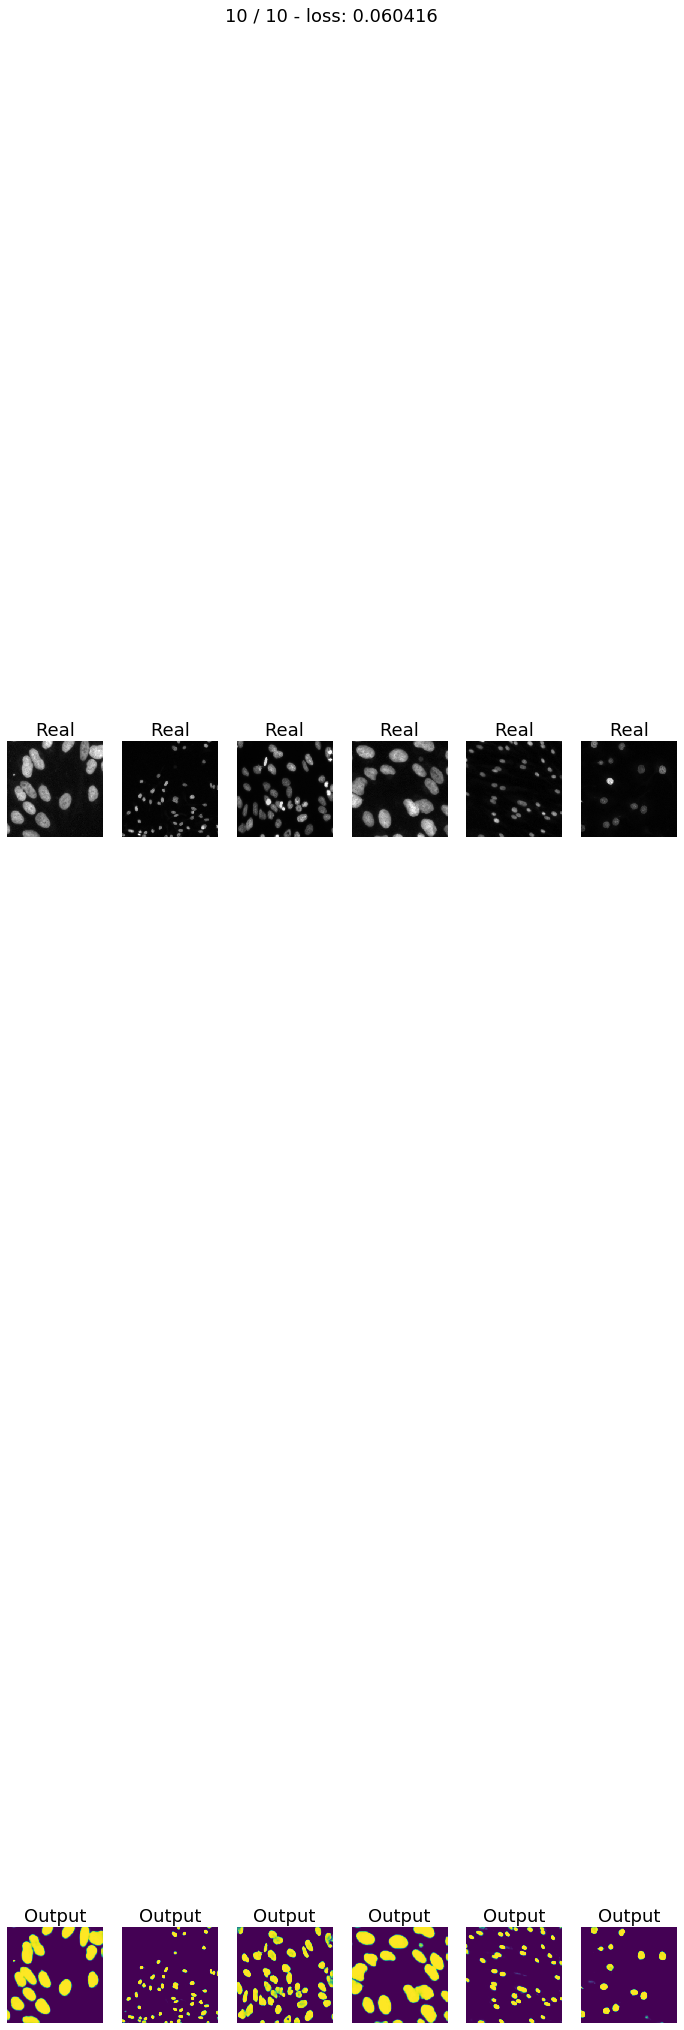

In [143]:
plt.figure(figsize=(10,10))
if useContour == False:
    train(model, optim.Adam(model.parameters(),1e-3), bce_loss, 10, data_tr, data_val)##60
else:
    train(model, optim.Adam(model.parameters(), 1e-3), 
          softmax_cross_entropy_customized, 
          30, data_tr, data_val)##60
    

## Compute IoU

In [149]:
# run with final model
SegPred = []
SegTrue = []
SegYeval = []

print(X.shape)
print(Y.shape)
print(Yeval.shape)
# print(val)

if usePyAug:
    image_transform = transforms.Compose([transforms.Grayscale(1)])
    geometric_transform = transforms.Compose([])
    
    if useContour == True:
        validset = NucleiSet(image_transform,geometric_transform,X[val],YwithContour[val])
    else:
        validset = NucleiSet(image_transform,geometric_transform,X[val],Y[val])
    print(len(validset))
    data_val_ordered = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=3)
else:
    # cancel shuffle
    data_val_ordered = DataLoader(list(zip(X[val]), Y[val, np.newaxis]), 
                                  batch_size=batch_size, shuffle=False)

print(X.shape)


model.eval()  # testing mode

i = 0
for data, label in data_val_ordered:
    if useContour == True:
        Y_hat = torch.softmax(model(data.to(device)),dim=1).detach().cpu()
    else:
        Y_hat = torch.sigmoid(model(data.to(device))).detach().cpu()
    ## check shuffle
    for image, image_label in zip(Y_hat,label):
# #         print(image.shape)
#         plt.figure()
#         plt.subplot(1,3,1)
        image = image.numpy().transpose(1,2,0)
        if image.shape[2] == 1:
            image = np.reshape(image,[image.shape[0],image.shape[1]])
#         plt.imshow(image)
#         plt.subplot(1,3,2)
        image_label = image_label.numpy()
# #         print(image_label.shape)
        image_label = image_label.transpose(1,2,0)
        if image_label.shape[2] == 1:
            image_label = np.reshape(image_label,[image_label.shape[0],image_label.shape[1]])
# #         print(image_label.shape)
#         plt.imshow(image_label)
#         plt.subplot(1,3,3)
#         plt.imshow(Yeval[val[i]])
        SegPred.append(image)
        SegTrue.append(image_label)
        SegYeval.append(Yeval[val[i]])
        i+=1
#     break

    
# for image, image_label, label_eval in zip(SegPred,SegTrue,SegYeval):
#     plt.figure()
#     plt.subplot(1,3,1)
#     plt.imshow(image)
#     plt.subplot(1,3,2)
#     plt.imshow(image_label)
#     plt.subplot(1,3,3)
#     plt.imshow(label_eval)
        

IndentationError: unexpected indent (<ipython-input-149-4c8038b967d6>, line 24)

In [145]:
def IoU(truth, pred):
    mask_int = truth & pred
    mask_union = truth | pred
    area_int = mask_int.sum()
    area_union = mask_union.sum()
#     print('%s, %s'%(area_int,area_union))
    return area_int / area_union

def evaluation(truth, pred, verbose = False, iou_threshold = 0.5):
    ## suppose pred has been watershed or labeled
    number_of_objects = np.unique(truth) ## remove background
    #print("iou_threshold:%s"%iou_threshold)
    
    TP = 0
    FP = 0
    FN = 0
    
    for ii in range(len(number_of_objects)-1):
        current_label = number_of_objects[ii + 1]
        mask_truth = truth  == current_label
        mask_intersect = pred[mask_truth]
        if not np.any(mask_intersect):
            FN+=1
            continue
        pred_labels, counts = np.unique(mask_intersect, return_counts = True)
        idx = np.argmax(counts)
        matched_label = pred_labels[idx]
        mask_pred = pred == matched_label
        iou = IoU(mask_truth, mask_pred)
        if verbose == True:
            print(pred_labels)
            print(iou)
        if iou >= iou_threshold:
            # correct
            TP+=1
            # mask out pred
            pred[mask_pred] = 0
    FP = len(np.unique(pred)) - 1
    precision = TP / (TP+FP+FN)
    return precision, TP, FP, FN
        

In [126]:
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import img_as_int, img_as_float
import scipy.ndimage as ndi #import label, generate_binary_structure
from skimage.feature import peak_local_max
from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.morphology import dilation

def tensor_to_grayimg(ts):
    img = img_as_float(ts)
    img = np.rollaxis(img,0,3)
    img = np.reshape(img,(img.shape[0],img.shape[1]))
    return img

def post_process(image, label):
    img = image.copy()
    im_label = label.copy()
    img[img <= 0.5] = 0
#     img[img > 0.5] = 1
#     img = ndi.binary_fill_holes(img)

#     torch.argmax(

    if useErosion == True:
        img = dilation(img,square(erosion_size))

    markers = np.zeros_like(img,np.int)
    markers[img < 0.5] = 1
    markers[img >= 0.5] = 2
    # process the watershed
    label_image = watershed(img, markers)
    # label image regions
    label_image_c, numbers = ndi.label(label_image-1)
    return img, im_label, label_image_c

def pose_process2(image, label):
    ## this comes the result of using contour
    img = np.argmax(image,axis=2)
    im_label = np.zeros_like(label,np.uint8)
    im_label[label[:,:,0] == 1,:] = 0
    im_label[label[:,:,1] == 1,:] = [255,0,0]
    im_label[label[:,:,2] == 1,:] = [0,0,255]
    
    img[img <= 0.5] = 0
    img[img >= 1.5] = 0

    markers = np.ones_like(img, np.int)*2
    markers[img < 0.5] = 1
    markers[img >= 1.5] = 3
    
    ## use contour and compute distace
#     coutour_make = img >= 1.5
#     distance_mask = ndi.morphology.distance_transform_edt(coutour_make)

    # process the watershed
    label_image = watershed(img, markers)
    
    label_image_c,_ = ndi.label(label_image - 1)
#     print(label_image_c.size)
    plt.imshow(label_image_c)
    
    return img, im_label, label_image_c
    

plt.rcParams['figure.figsize'] = [12, 40]
plt.rc('font', size=15)          # controls default text sizes

j = 0
# show final results
plt.figure()
for image, image_label, label_eval in zip(SegPred,SegTrue,SegYeval):
    if useContour == False:
        img, im_label, label_image_c = post_process(image, image_label)
    else:
        ## another way of getting label
        img, im_label, label_image_c = pose_process2(image, image_label)
    
#         print(np.unique(label_image_c))
    precision, TP, FP, FN = evaluation(label_eval, label_image_c)

    print("precision %s, TP %s, FP %s, FN %s"%(precision, TP, FP, FN))

#         precision, TP, FP, FN = evaluation(Yeval[val[i]].copy(), label_image_c, True)

#         print(numbers)
#         label_image_c = label2rgb(label_image)
    plt.subplot(9, 6, j*2+1)
    plt.imshow(label_image_c,cmap=plt.cm.nipy_spectral,)
    plt.title('Predict',fontsize='medium')
    plt.subplot(9, 6, j*2+2)
    plt.imshow(label_eval,cmap=plt.cm.nipy_spectral,)
    plt.title('Truth',fontsize='medium')
    j += 1
    if j == 25:
        j = 0
        plt.figure()
    
    

<Figure size 864x2880 with 0 Axes>

In [146]:
def evaluate_all(true, pred, t):
    precisions = []
    for image, true_label in zip(pred,true):
        ## this comes the result of using contour
        if useContour == True:
            img = np.argmax(image,axis=2)

            markers = np.ones_like(img, np.int)*2
            markers[img < 0.5] = 1
            markers[img > 1.5] = 3

            # process the watershed
            label_image = watershed(img, markers)
            label_image_c,_ = ndi.label(label_image - 1)
        else:
            img = image
            img[img <= 0.5] = 0
#             img[img > 0.5] = 1
            if useErosion == True:
                img = dilation(img,square(erosion_size))
            markers = np.zeros_like(img,np.int)
            markers[img < 0.5] = 1
            markers[img >= 0.5] = 2
            # process the watershed
            label_image = watershed(img, markers)
            # label image regions
            label_image_c, numbers = ndi.label(label_image-1)

        precision, _, _, _ = evaluation(true_label.copy(), label_image_c.copy(), 
                                        iou_threshold=t)
        precisions.append(precision)
    return precisions

In [147]:
## iterate with iou threshold and plot curve
ts = np.arange(0.5,0.8,0.05,np.float32)
mean_precision = np.zeros_like(ts, np.float32)
k = 0
for t in tqdm(ts):
    print(t)
    precisions_of_current_threshold = evaluate_all(SegYeval, SegPred, t)
    precisions_of_current_threshold = np.array(precisions_of_current_threshold,np.float32)
    print(precisions_of_current_threshold.mean(axis=0))
    mean_precision[k] = precisions_of_current_threshold.mean()
    k+=1

0.5
nan
0.55
nan
0.6
nan
0.65000004
nan
0.70000005
nan
0.75000006
nan
0.8000001
nan


/home/xiahaa/.conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/xiahaa/.conda/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
plt.plot(ts, mean_precision,'-D',c='#990000',alpha=0.8,linewidth=2,label='mean precision')
plt.title('Precision over IoU threshold')
plt.xlabel('IoU Threshold')
plt.ylabel('Precision')
plt.grid(True)
plt.savefig('./figures/rgb.png',dpi=300)

## Questions: 
1. evaluation on resized image or on raw mask image?
    1.1. if on raw image: the raw masks are separate, i.e. each pixel belongs to 1 mask. (however, if use component connected algorithm on the combined mask image, objects may be treated as 1)
    1.2  if on the resize combined mask, because of downsampling, the resized combined mask will be connected more probably.
    
2. ~~about find true positive, false posititve, false negative: use once or more? **if one predicted hits, should we make a flag and for later identification, we never use predicts that has been marked with a flag?** if not use flag, is it fair?~~

Answer from Kaggle: 
> The metric checks that the pairs are sorted, positive, and **the decoded pixel values are not duplicated**. It also checks that **no two predicted masks for the same image are overlapping**.

> https://www.kaggle.com/c/data-science-bowl-2018/discussion/47864#latest-314862

After viewing the submission csv files:
1. instance segmentation: each predicted object can only be used once;
2. use run-length encoding for competition:
    2.1 for one image, if there are multiple nucleus, then just generate multiple lines of run-length encoding. see **stage1_train_labels.csv** as an example.
3. stage1_solution.csv is the labels for stage1_test images.
4. stage2_solution_final.csv is the labels for stage2_test images.




very challenging:
> Left is contrast enhanced image # 'f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55' Right is the image labeled using the mask from the training set. Are these small objects really nuclei? bad annotation? ![raw_image](https://i.imgur.com/X7rdSRC.png)

another example:
masks with holes, masks with noise (single pixel nuclei)
![sample_image0](
https://www.kaggle.io/svf/2357892/9ec4f3ca4132c19296b2c63ed7f924df/__results___files/__results___4_0.png)
![sample_image1](
https://www.kaggle.io/svf/2357892/9ec4f3ca4132c19296b2c63ed7f924df/__results___files/__results___6_0.png)
![sample_image2](https://www.kaggle.io/svf/2359003/4a7901ca80e0619a44a2995a431e4e3b/__results___files/__results___8_0.png)

In [52]:
d=np.array([1, 1, 2, 2, 3, 3])
a,b,c = np.unique(d,return_inverse=True,return_counts=True)
print(a)
print(b)
print(c)
print(a[b])
b = np.zeros([3,2])
all_zeros = not np.any(b)
print(all_zeros)

[1 2 3]
[0 0 1 1 2 2]
[2 2 2]
[1 1 2 2 3 3]
True


In [27]:
ts = np.arange(0.5,0.8,0.05,np.float32)
print(ts)

[0.5        0.55       0.6        0.65000004 0.70000005 0.75000006
 0.8000001 ]


In [21]:
import numpy as np
from skimage.morphology import square
from skimage.morphology import erosion
bright_square = np.array([[0, 1, 0, 0, 0],
                          [1, 1, 1, 1, 0],
                          [1, 1, 1, 1, 0],
                          [1, 1, 1, 1, 0],
                          [0, 0, 0, 0, 0]], dtype=np.float32)
mask = np.eye(3,3,dtype=np.float32)
print(mask)
erosion(bright_square,square(3))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)